## alenxet architecture with sgd momentum optimizer 

In [1]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tf_data_augmentation import data_augment
import numpy as np

In [2]:
tf.keras.utils.set_random_seed(42) # sets the Python, NumPy and TensorFlow seed
tf.config.experimental.enable_op_determinism() # forces threads to work in deterministic way

## Data load and splitting

In [3]:
(train_ds, val_ds), info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, as_supervised=True, split=['train+test[:70%]', 'test[70%:]'], download=False)

# Calculate the number of classes i.e.37
NUM_CLASSES = info.features['label'].num_classes
num_train = len(train_ds)
num_val = len(val_ds)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## hypermaters

In [4]:
import os
BATCH_SIZE = 256
IMAGE_SIZE = 128
# Set environment variables
os.environ['NUM_CLASSES'] = str(NUM_CLASSES)
os.environ['BATCH_SIZE'] = str(BATCH_SIZE)
os.environ['IMAGE_SIZE'] = str(IMAGE_SIZE)

## visualization

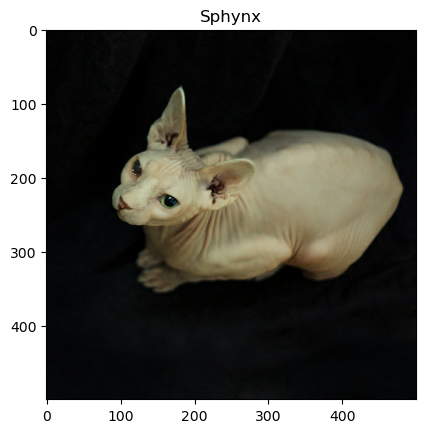

In [5]:
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title( get_label_name( label ) )

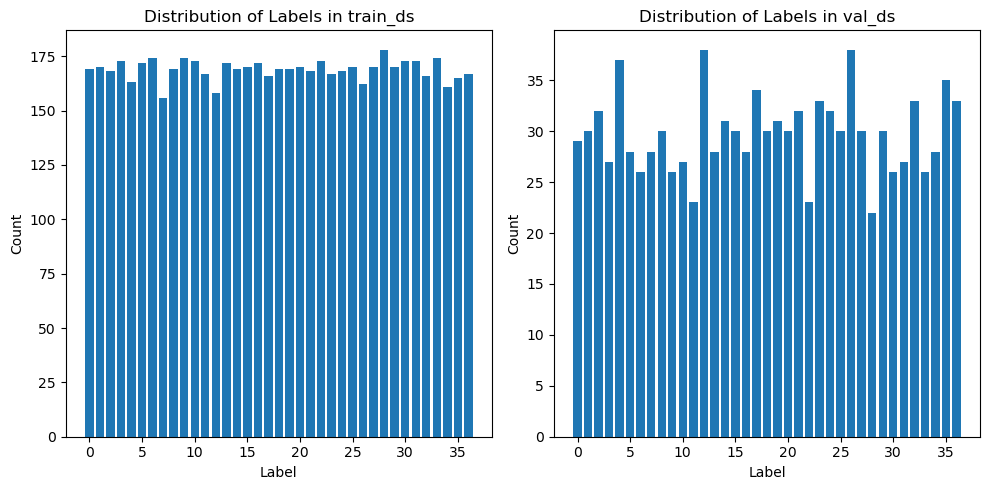

In [6]:
# Get the labels from train_ds and val_ds
train_labels = np.array([label.numpy() for _, label in train_ds])
val_labels = np.array([label.numpy() for _, label in val_ds])

# Count the occurrences of each label in train_ds and val_ds
train_label_counts = np.bincount(train_labels)
val_label_counts = np.bincount(val_labels)

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(train_label_counts)), train_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_ds')

plt.subplot(1, 2, 2)
plt.bar(range(len(val_label_counts)), val_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in val_ds')

plt.tight_layout()
plt.show()

## Data Augmentation

In [7]:
train_ds, val_ds = data_augment(train_ds, val_ds)

In [8]:
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


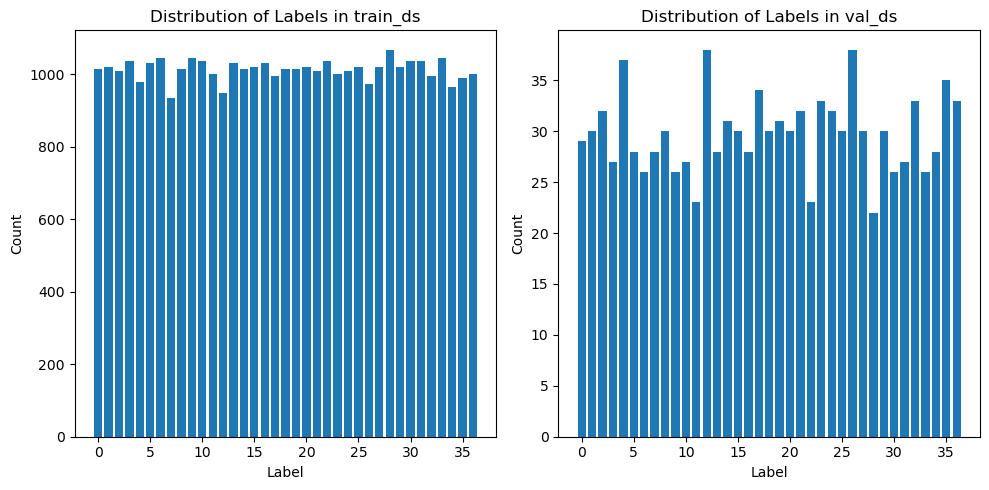

In [9]:
# Get the labels from train_ds and val_ds
train_labels = np.array([])
val_labels = np.array([])

for images, labels in train_ds:
    train_labels = np.append(train_labels, np.argmax(labels.numpy(), axis=1))

for images, labels in val_ds:
    val_labels = np.append(val_labels, np.argmax(labels.numpy(), axis=1))

# Count the occurrences of each label in train_ds and val_ds
train_label_counts = np.bincount(train_labels.astype(int))
val_label_counts = np.bincount(val_labels.astype(int))

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(train_label_counts)), train_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_ds')

plt.subplot(1, 2, 2)
plt.bar(range(len(val_label_counts)), val_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in val_ds')

plt.tight_layout()
plt.show()

In [9]:
def alex_net(input_shape, classes: int = 37) -> k.Model:
    l2_reg = k.regularizers.l2(0.0005)  # L2 regularization factor
    k.utils.set_random_seed(42)
    alexnet = k.Sequential([
        k.layers.Input(shape=input_shape),
        k.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu',
                        kernel_initializer="he_uniform", bias_initializer=k.initializers.LecunUniform(), 
                        kernel_regularizer=l2_reg),
        k.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2, alpha=0.0001, beta=0.75)),
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        k.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer="he_uniform", bias_initializer=k.initializers.LecunUniform(), 
                        kernel_regularizer=l2_reg),
        k.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2, alpha=0.0001, beta=0.75)),
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        k.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.LecunUniform(), 
                        kernel_regularizer=l2_reg),
        
        k.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.LecunUniform(), 
                        kernel_regularizer=l2_reg),
        
        k.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.LecunUniform(), 
                        kernel_regularizer=l2_reg),
        
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        k.layers.Flatten(),

        k.layers.Dense(units=4096, activation='relu', kernel_initializer="he_uniform", bias_initializer=k.initializers.LecunUniform(), 
                       kernel_regularizer=l2_reg),
        k.layers.Dropout(0.5),
        
        k.layers.Dense(units=4096, activation='relu', kernel_initializer="he_uniform", bias_initializer=k.initializers.LecunUniform(), 
                       kernel_regularizer=l2_reg),
        k.layers.Dropout(0.5),
    ])
    alexnet.add(k.layers.Dense(units=classes, activation='softmax', kernel_initializer="glorot_uniform", 
                               bias_initializer=k.initializers.LecunUniform(), kernel_regularizer=l2_reg))
    return alexnet
alexnet_model = alex_net((IMAGE_SIZE, IMAGE_SIZE, 3), NUM_CLASSES)
alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 30, 30, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                    

In [10]:
alexnet_model.compile(
        optimizer=k.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = alexnet_model.fit(train_ds, epochs=10, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
147/147 [==============================] - 117s 360ms/step - loss: 13.3412 - categorical_accuracy: 0.0285 - val_loss: 13.2058 - val_categorical_accuracy: 0.0418
Epoch 2/10
147/147 [==============================] - 47s 319ms/step - loss: 13.2426 - categorical_accuracy: 0.0287 - val_loss: 13.1929 - val_categorical_accuracy: 0.0509
Epoch 3/10
147/147 [==============================] - 47s 322ms/step - loss: 13.2193 - categorical_accuracy: 0.0324 - val_loss: 13.1838 - val_categorical_accuracy: 0.0454
Epoch 4/10
147/147 [==============================] - 47s 319ms/step - loss: 13.2065 - categorical_accuracy: 0.0357 - val_loss: 13.1744 - val_categorical_accuracy: 0.0509
Epoch 5/10
147/147 [==============================] - 47s 317ms/step - loss: 13.1975 - categorical_accuracy: 0.0369 - val_loss: 13.1663 - val_categorical_accuracy: 0.0545
Epoch 6/10
147/147 [==============================] - 47s 319ms/step - loss: 13.1863 - categorical_accuracy: 0.0379 - val_loss: 13.1558 - val_ca

In [11]:
hist = alexnet_model.fit(train_ds, epochs=10, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
147/147 [==============================] - 47s 319ms/step - loss: 13.1370 - categorical_accuracy: 0.0528 - val_loss: 13.0971 - val_categorical_accuracy: 0.0690
Epoch 2/10
147/147 [==============================] - 47s 320ms/step - loss: 13.1221 - categorical_accuracy: 0.0545 - val_loss: 13.0808 - val_categorical_accuracy: 0.0754
Epoch 3/10
147/147 [==============================] - 48s 326ms/step - loss: 13.1115 - categorical_accuracy: 0.0570 - val_loss: 13.0645 - val_categorical_accuracy: 0.0708
Epoch 4/10
147/147 [==============================] - 48s 325ms/step - loss: 13.0992 - categorical_accuracy: 0.0583 - val_loss: 13.0456 - val_categorical_accuracy: 0.0772
Epoch 5/10
147/147 [==============================] - 48s 327ms/step - loss: 13.0827 - categorical_accuracy: 0.0645 - val_loss: 13.0271 - val_categorical_accuracy: 0.0763
Epoch 6/10
147/147 [==============================] - 49s 332ms/step - loss: 13.0671 - categorical_accuracy: 0.0644 - val_loss: 13.0059 - val_cat

In [12]:
alexnet_model.compile(
        optimizer=k.optimizers.SGD(learning_rate=0.00005, momentum=0.9),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = alexnet_model.fit(train_ds, epochs=10, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
147/147 [==============================] - 49s 326ms/step - loss: 12.9939 - categorical_accuracy: 0.0734 - val_loss: 12.9100 - val_categorical_accuracy: 0.1026
Epoch 2/10
147/147 [==============================] - 48s 327ms/step - loss: 12.9890 - categorical_accuracy: 0.0739 - val_loss: 12.9011 - val_categorical_accuracy: 0.1063
Epoch 3/10
147/147 [==============================] - 49s 330ms/step - loss: 12.9803 - categorical_accuracy: 0.0774 - val_loss: 12.8915 - val_categorical_accuracy: 0.1063
Epoch 4/10
147/147 [==============================] - 48s 324ms/step - loss: 12.9747 - categorical_accuracy: 0.0754 - val_loss: 12.8807 - val_categorical_accuracy: 0.1054
Epoch 5/10
147/147 [==============================] - 48s 326ms/step - loss: 12.9673 - categorical_accuracy: 0.0767 - val_loss: 12.8732 - val_categorical_accuracy: 0.1054
Epoch 6/10
147/147 [==============================] - 48s 326ms/step - loss: 12.9588 - categorical_accuracy: 0.0795 - val_loss: 12.8606 - val_cat

In [13]:
alexnet_model.compile(
        optimizer=k.optimizers.SGD(learning_rate=0.00001, momentum=0.9),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = alexnet_model.fit(train_ds, epochs=10, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
147/147 [==============================] - 50s 338ms/step - loss: 12.9262 - categorical_accuracy: 0.0829 - val_loss: 12.8242 - val_categorical_accuracy: 0.1135
Epoch 2/10
147/147 [==============================] - 46s 313ms/step - loss: 12.9238 - categorical_accuracy: 0.0839 - val_loss: 12.8223 - val_categorical_accuracy: 0.1099
Epoch 3/10
147/147 [==============================] - 46s 315ms/step - loss: 12.9241 - categorical_accuracy: 0.0825 - val_loss: 12.8205 - val_categorical_accuracy: 0.1108
Epoch 4/10
147/147 [==============================] - 47s 316ms/step - loss: 12.9207 - categorical_accuracy: 0.0835 - val_loss: 12.8185 - val_categorical_accuracy: 0.1099
Epoch 5/10
147/147 [==============================] - 46s 309ms/step - loss: 12.9194 - categorical_accuracy: 0.0824 - val_loss: 12.8156 - val_categorical_accuracy: 0.1153
Epoch 6/10
147/147 [==============================] - 46s 312ms/step - loss: 12.9158 - categorical_accuracy: 0.0847 - val_loss: 12.8138 - val_cat